In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv('data.csv')
df.head()

,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,HasPhotovoltaics,HeatingType,HasFiberglass,IsFurnished,...,HasFireplace,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,WindowModelNames,Price
0,1.0,1.0,57.0,Rural,7.0,Excellent,NaN,Gas,True,True,...,False,Good,Good,Excellent,Good,39.0,5.00,NaN,IICU1 Wood PJS7VF,357.03435
1,2.0,2.0,92.0,Suburban,29.0,NaN,False,Electricity,False,False,...,False,Good,Good,Good,Excellent,5.0,2.62,NaN,Steel 4LQ Window,119.93235
2,2.0,2.0,100.0,Suburban,36.0,Good,NaN,Gas,False,True,...,False,Excellent,Good,Poor,Good,15.0,2.40,99.0,7TN Wood R0XS7U,143.31661
3,5.0,2.0,150.0,Urban,51.0,Excellent,False,Gas,False,True,...,False,Good,Excellent,Excellent,Poor,39.0,2.68,NaN,Z04Z Aluminum VNQYWOV,313.29877
4,NaN,1.0,-289.0,Rural,62.0,NaN,NaN,Electricity,True,True,...,False,Good,Poor,Good,Good,5.0,3.48,54.6,Steel RL0JBO,299.93697


## Handling Missing Values

<AxesSubplot:>

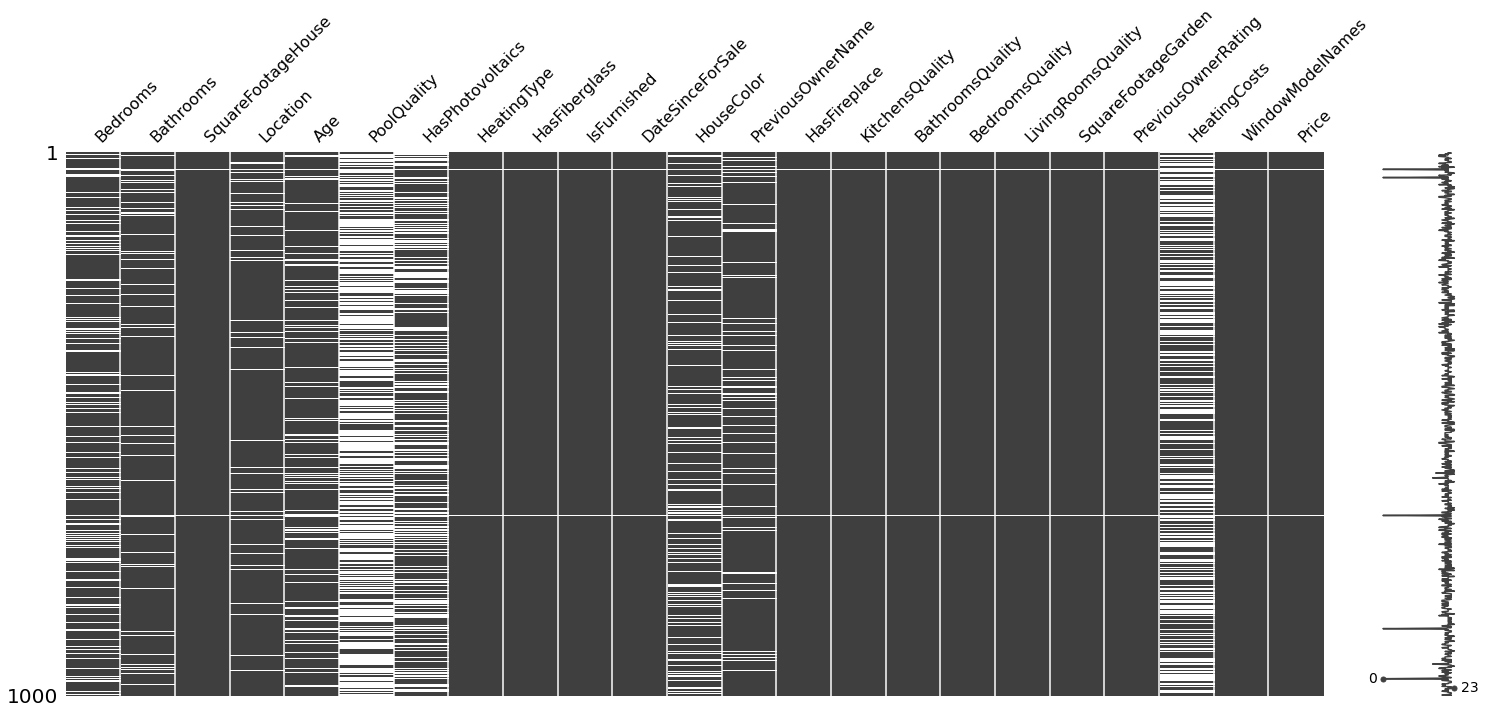

In [3]:
# Visualize missing values
msno.matrix(df)

In [4]:
def computeCatNumFeatures(df):
    categoricalF = df.select_dtypes(include=['object']).columns
    numericalF   = df.select_dtypes(include=[np.number]).columns
    print(f"Categorical: \t({len(categoricalF)}){list(categoricalF)}\n\nNumerical: \t({len(numericalF)}) {list(numericalF)}")
    return numericalF, categoricalF

In [5]:
numericalF, categoricalF = computeCatNumFeatures(df)

Categorical: 	(15)['Location', 'PoolQuality', 'HasPhotovoltaics', 'HeatingType', 'HasFiberglass', 'IsFurnished', 'DateSinceForSale', 'HouseColor', 'PreviousOwnerName', 'HasFireplace', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames']

Numerical: 	(8) ['Bedrooms', 'Bathrooms', 'SquareFootageHouse', 'Age', 'SquareFootageGarden', 'PreviousOwnerRating', 'HeatingCosts', 'Price']


This Function:
- Removes the outliers by checking the IQR (Inter-Quartile-Range): if each point satisfies the constraint then it is kept otherwise set to NaN;
- Set the values of binary features to Nan if the value is 0, with the assumption that if Nan then the feature is missing;
- Computes the days since when the house has been on sale computing the delta time between each date and the max value among the ones in the DS;
- Replaces some typo with the correct word and removes redundant information;
- Drops all the instances where the Target variable assumes NaN.

In [6]:
def baseProcessing(df):
    # Putting NaN in place of outliers - basic outliers removal using IQR
    def apply_iqr_limits(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

    df['HeatingCosts']          = apply_iqr_limits(df['HeatingCosts'])
    df['SquareFootageHouse']    = apply_iqr_limits(df['SquareFootageHouse'])
    df['PreviousOwnerRating']   = apply_iqr_limits(df['PreviousOwnerRating'])
    df['Age']                   = apply_iqr_limits(df['Age'])
    df['Price']                 = apply_iqr_limits(df['Price'])
    df['Age'] = df['Age'].apply(lambda x: x if x >= 0 else np.nan)  # Negative age to Nan

    # Setting the values from Nan to 0, assuming that no value - no feature
    for col in ['HasPhotovoltaics', 'HasFiberglass', 'IsFurnished', 'HasFireplace']:
        df.loc[:, col] = df[col].fillna(0)
    df['PoolQuality'] = df['PoolQuality'].fillna('None')

    # Binary to INT type
    df['HasPhotovoltaics']  = df['HasPhotovoltaics'].astype(int)
    df['HasFiberglass']     = df['HasFiberglass'].astype(int)
    df['IsFurnished']       = df['IsFurnished'].astype(int)
    df['HasFireplace']      = df['HasFireplace'].astype(int)

    # Handling dates: inserting delta days from each date to the most recent one
    df['DateSinceForSale'] = (max(pd.to_datetime(df['DateSinceForSale'])) - pd.to_datetime(df['DateSinceForSale'])).dt.days

    # Replacing the typo 'Suburbann' with the correct word 'Suburban'
    df['Location'] = df['Location'].replace('Suburbann', 'Suburban')
    # Remove redundant info
    df['HeatingType'] = df['HeatingType'].replace({'Electricity': 'Electric', 'Oil Heating': 'Oil'})

    # Keeping only material information regarding feature 'WindowModelNames'
    df['WindowModelNames'] = df['WindowModelNames'].astype(str)
    df['WindowModelNames'] = df['WindowModelNames'].apply(lambda x: 'Steel' if 'Steel' in x else ('Wood' if 'Wood' in x else 'Aluminium'))

    # Removing the instances where Price is NaN
    df = df.dropna(subset=['Price'], inplace=False).copy()
    return df

Compute the missing values by computing the mean of the numerical features and the mode for the categorical ones

In [7]:
def handleMissing(df):
    filledDF = df.copy()

    # Numerical
    filledDF['Age'] = filledDF['Age'].fillna(df['Age'].mean())
    filledDF['SquareFootageHouse'] = filledDF['SquareFootageHouse'].fillna(df['SquareFootageHouse'].mean())
    filledDF['SquareFootageGarden'] = filledDF['SquareFootageGarden'].fillna(df['SquareFootageGarden'].mean())
    filledDF['Bathrooms'] = filledDF['Bathrooms'].fillna(round(filledDF['Bathrooms'].mean()))
    filledDF['Bedrooms'] = filledDF['Bedrooms'].fillna(round(filledDF['Bedrooms'].mean()))

    # Categorical
    filledDF['WindowModelNames'] = filledDF['WindowModelNames'].fillna(filledDF['WindowModelNames'].mode()[0])
    filledDF['HouseColor'] = filledDF['HouseColor'].fillna(filledDF['HouseColor'].mode()[0])
    filledDF['PreviousOwnerName'] = filledDF['PreviousOwnerName'].fillna(filledDF['PreviousOwnerName'].mode()[0])
    filledDF['Location'] = filledDF['Location'].fillna(df['Location'].mode()[0])
    return filledDF


Boxplots before/after the baseProcessing

Before


array([[<AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Bathrooms'}>,
        <AxesSubplot:title={'center':'SquareFootageHouse'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SquareFootageGarden'}>,
        <AxesSubplot:title={'center':'PreviousOwnerRating'}>],
       [<AxesSubplot:title={'center':'HeatingCosts'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

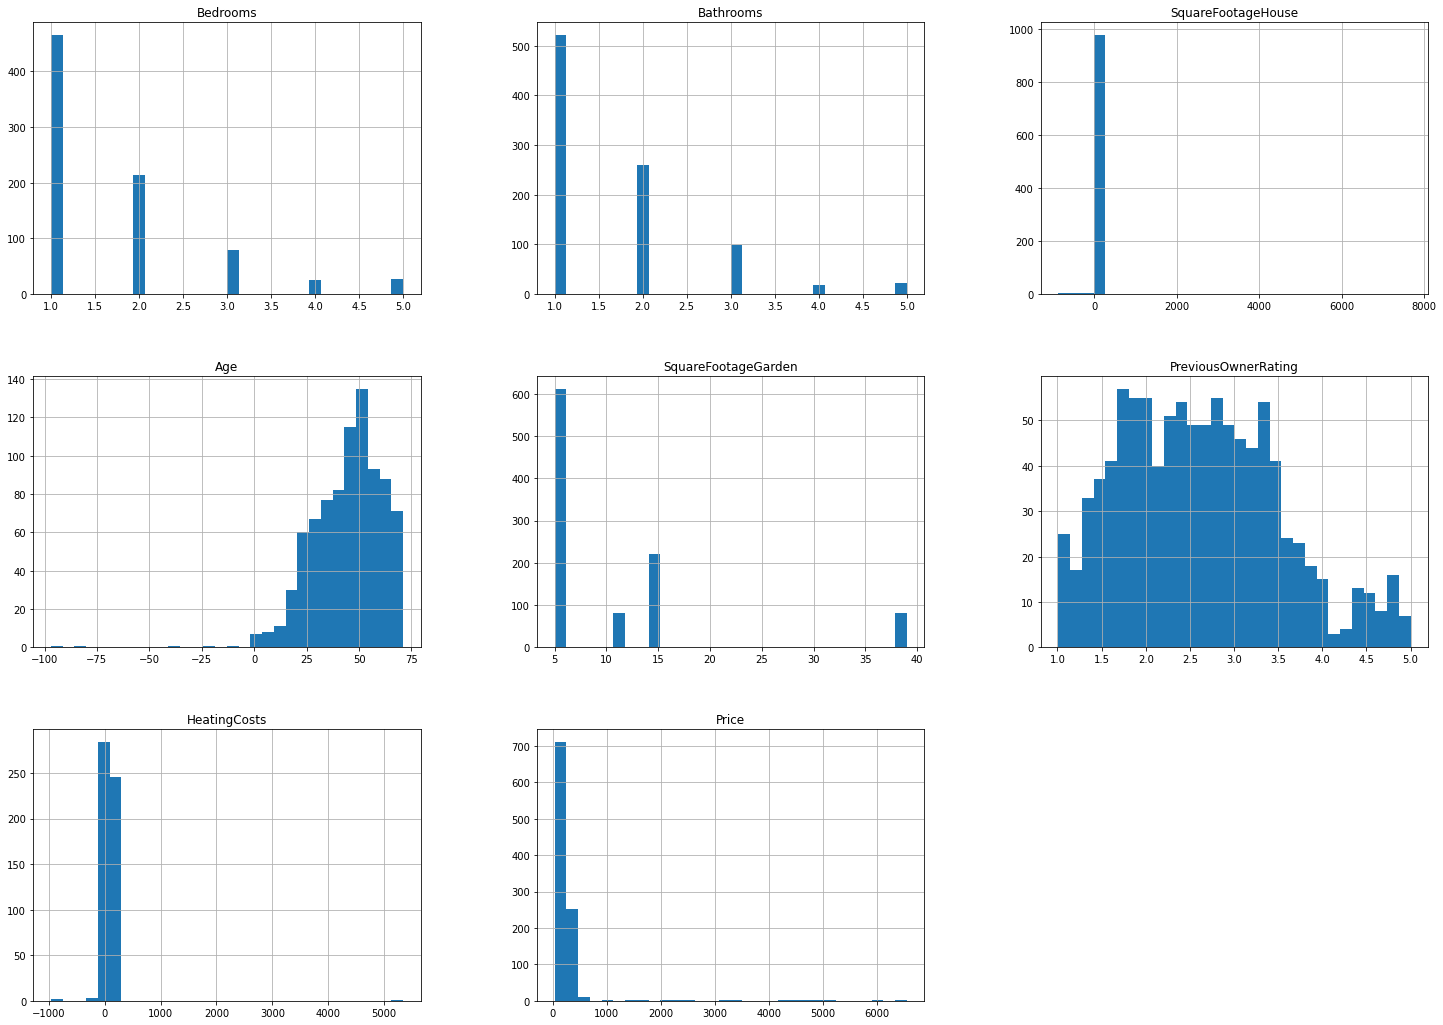

In [8]:
print("Before")
df.hist(bins=30, figsize=(25, 18))

After


array([[<AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Bathrooms'}>,
        <AxesSubplot:title={'center':'SquareFootageHouse'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'HasPhotovoltaics'}>,
        <AxesSubplot:title={'center':'HasFiberglass'}>,
        <AxesSubplot:title={'center':'IsFurnished'}>,
        <AxesSubplot:title={'center':'DateSinceForSale'}>],
       [<AxesSubplot:title={'center':'HasFireplace'}>,
        <AxesSubplot:title={'center':'SquareFootageGarden'}>,
        <AxesSubplot:title={'center':'PreviousOwnerRating'}>,
        <AxesSubplot:title={'center':'HeatingCosts'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

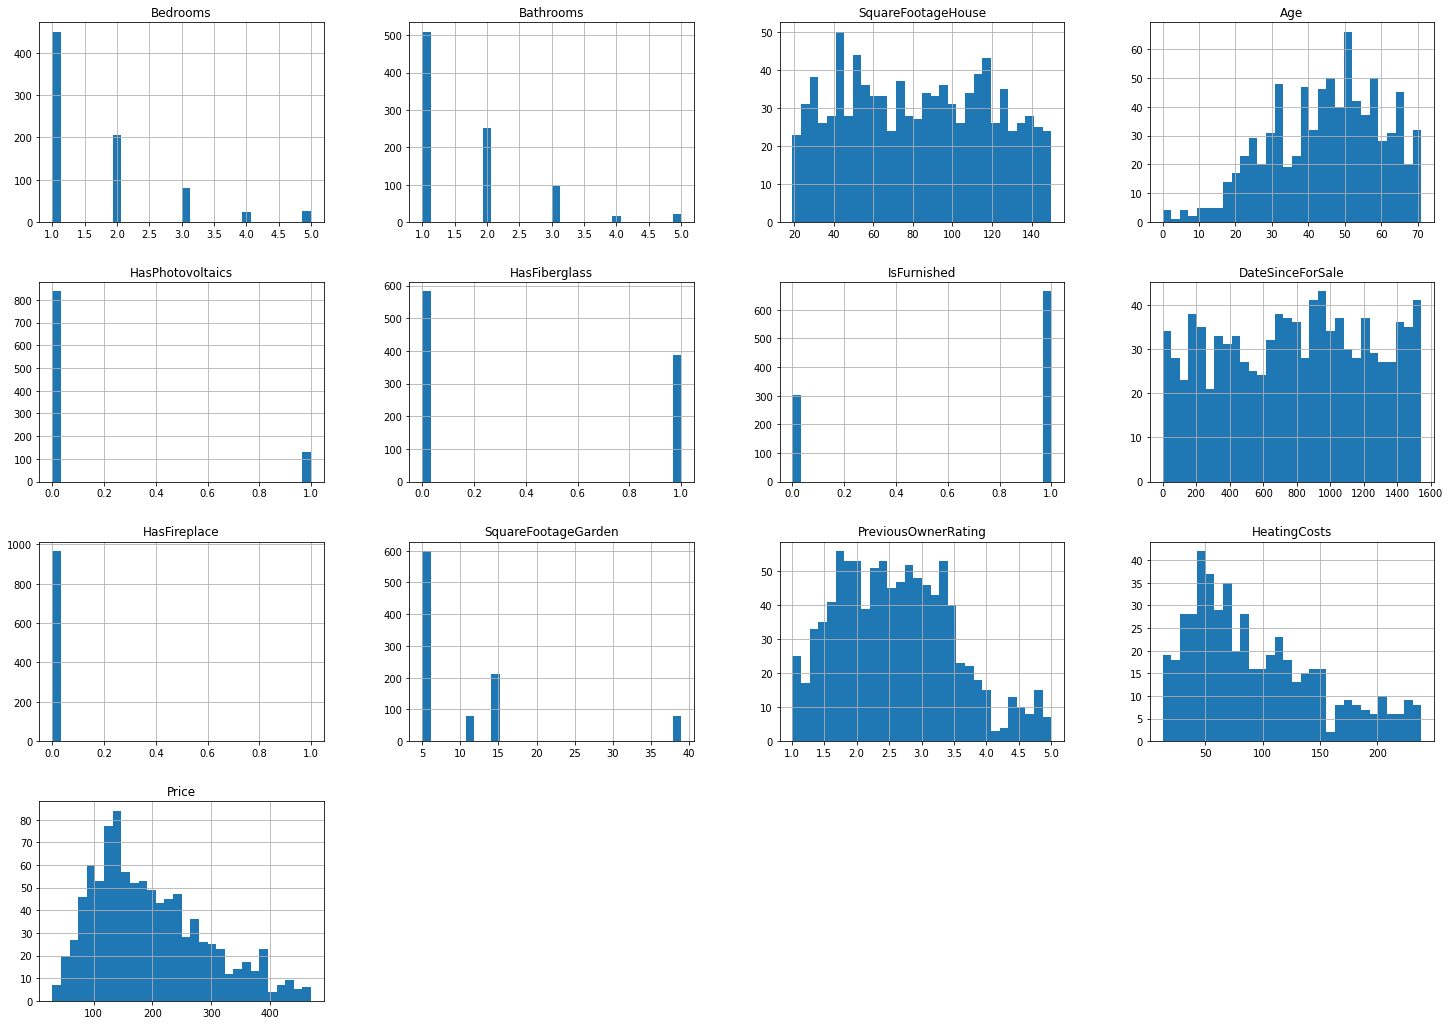

In [9]:
df_clean = baseProcessing(df)
print("After")
df_clean.hist(bins=30, figsize=(25, 18))

<AxesSubplot:>

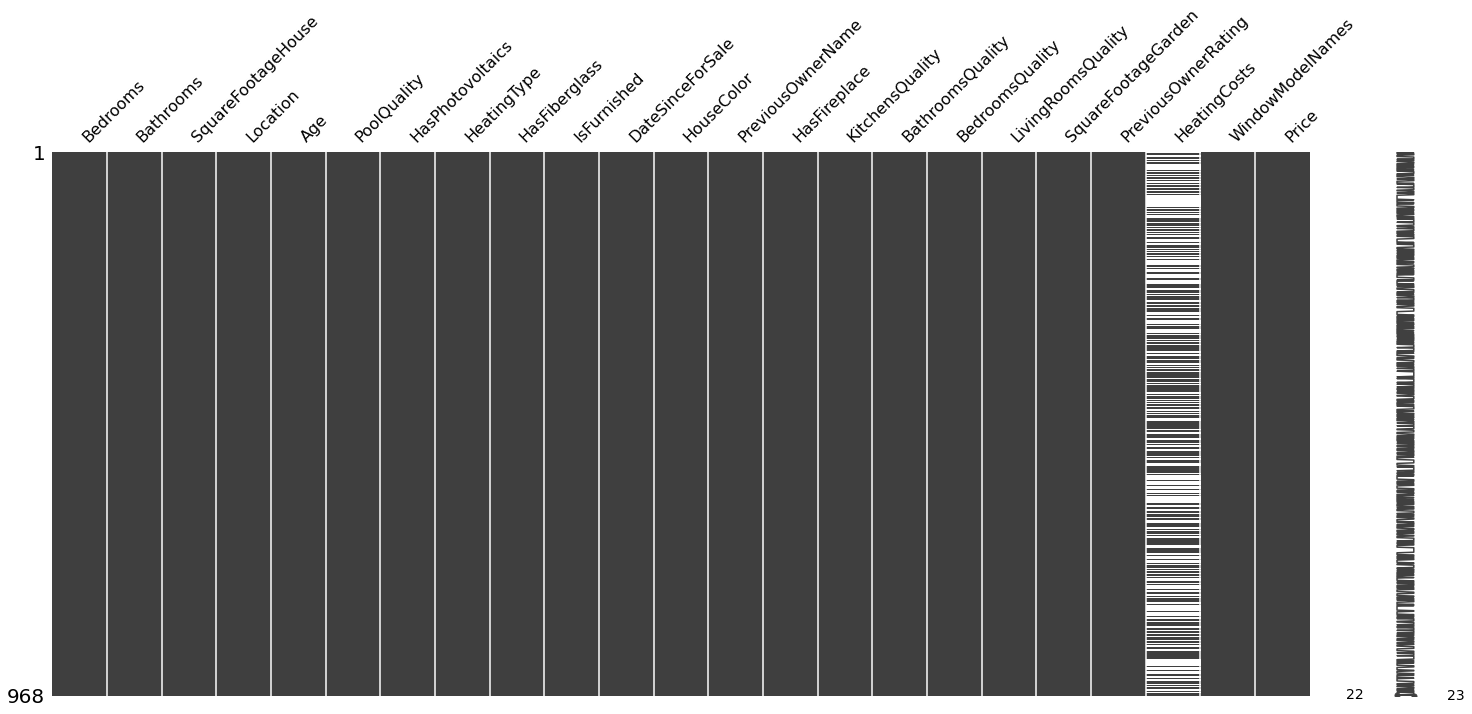

In [10]:
df_clean = handleMissing(df_clean)
msno.matrix(df_clean)

Let's analyze the `HeatingCosts` behavior since almost half of the values are missing.

Non-missing values: 515


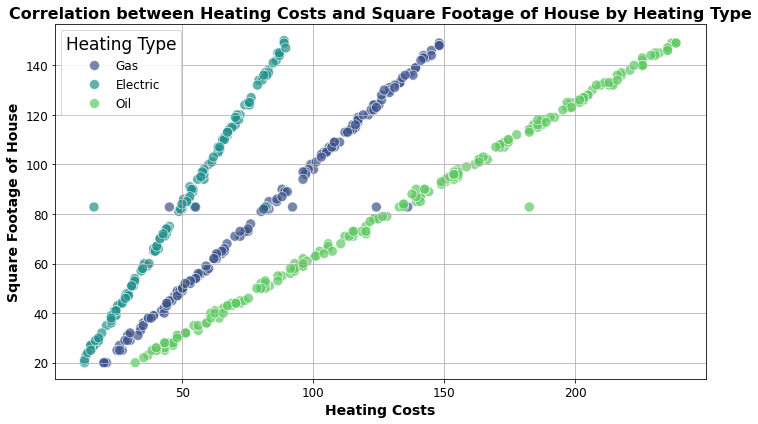

In [11]:
def plotHeating(df):
    df1 = df.dropna(subset=['HeatingCosts'])
    print(f"Non-missing values: {len(df1['HeatingCosts'])}")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='HeatingCosts', y='SquareFootageHouse', hue='HeatingType', palette='viridis', s=100, alpha=0.7)
    plt.title('Correlation between Heating Costs and Square Footage of House by Heating Type', fontsize=16, fontweight='bold')
    plt.xlabel('Heating Costs', fontsize=14, fontweight='bold')
    plt.ylabel('Square Footage of House', fontsize=14, fontweight='bold')
    plt.legend(title='Heating Type', fontsize=12, title_fontsize='17')
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plotHeating(df_clean)

In order to fill the `HeatingCosts` missing values, I want to perform a Linear regression for each 'type' of gas, by looking at the `SquareFootageHouse`. Also I see that there are some outliers.

In [12]:
from scipy.stats import linregress
def linRegHeatingCost(df):
    filledDF = df.copy()

    # Group the data by 'HeatingType'
    grouped = df.groupby('HeatingType')
    for _, group in grouped:
        # Filter out rows with missing 'HeatingCosts'
        valid_rows = group.dropna(subset=['HeatingCosts'])
        X_train = valid_rows['SquareFootageHouse'].values
        y_train = valid_rows['HeatingCosts'].values

        # Fit a linear regression model using linregress
        slope, intercept, _, _, _ = linregress(X_train, y_train)
        X_group = group['SquareFootageHouse'].values.reshape(-1, 1)
        predicted_values = slope * X_group + intercept

        # Calculate residuals in order to find some outliers and replace them with the right value
        # according to the linear regression ('2' is a value for std dev)
        residuals = group['HeatingCosts'] - predicted_values.flatten()
        threshold = 2 * np.std(residuals)

        # Replace outliers with predicted values
        group.loc[np.abs(residuals) > threshold, 'HeatingCosts'] = predicted_values[np.abs(residuals) > threshold]
        filledDF.loc[group.index, 'HeatingCosts'] = group['HeatingCosts']

        # Fill the missing values with the predicted ones
        X_missing = group[group['HeatingCosts'].isna()]['SquareFootageHouse'].values
        if len(X_missing) > 0:
            predicted_values = slope * X_missing + intercept
            # Get the index of rows with missing 'HeatingCosts' in the original DataFrame
            index_missing = group[group['HeatingCosts'].isna()].index
            # Set predicted values in the filled DataFrame using the index
            filledDF.loc[index_missing, 'HeatingCosts'] = predicted_values
    return filledDF

Non-missing values: 968


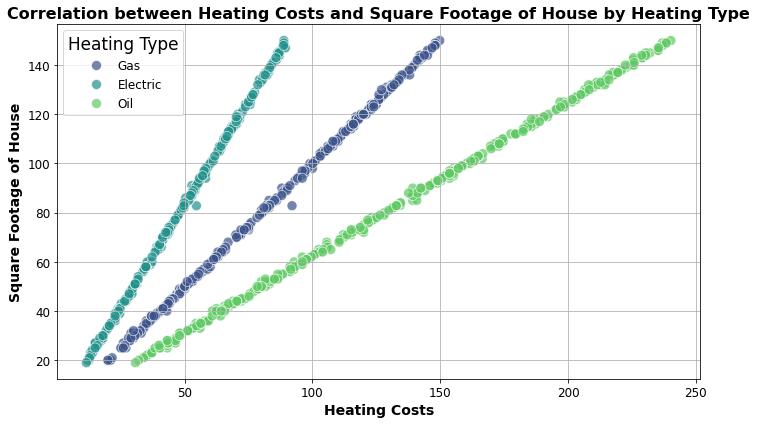

In [13]:
df_clean = linRegHeatingCost(df_clean)
plotHeating(df_clean)


<AxesSubplot:>

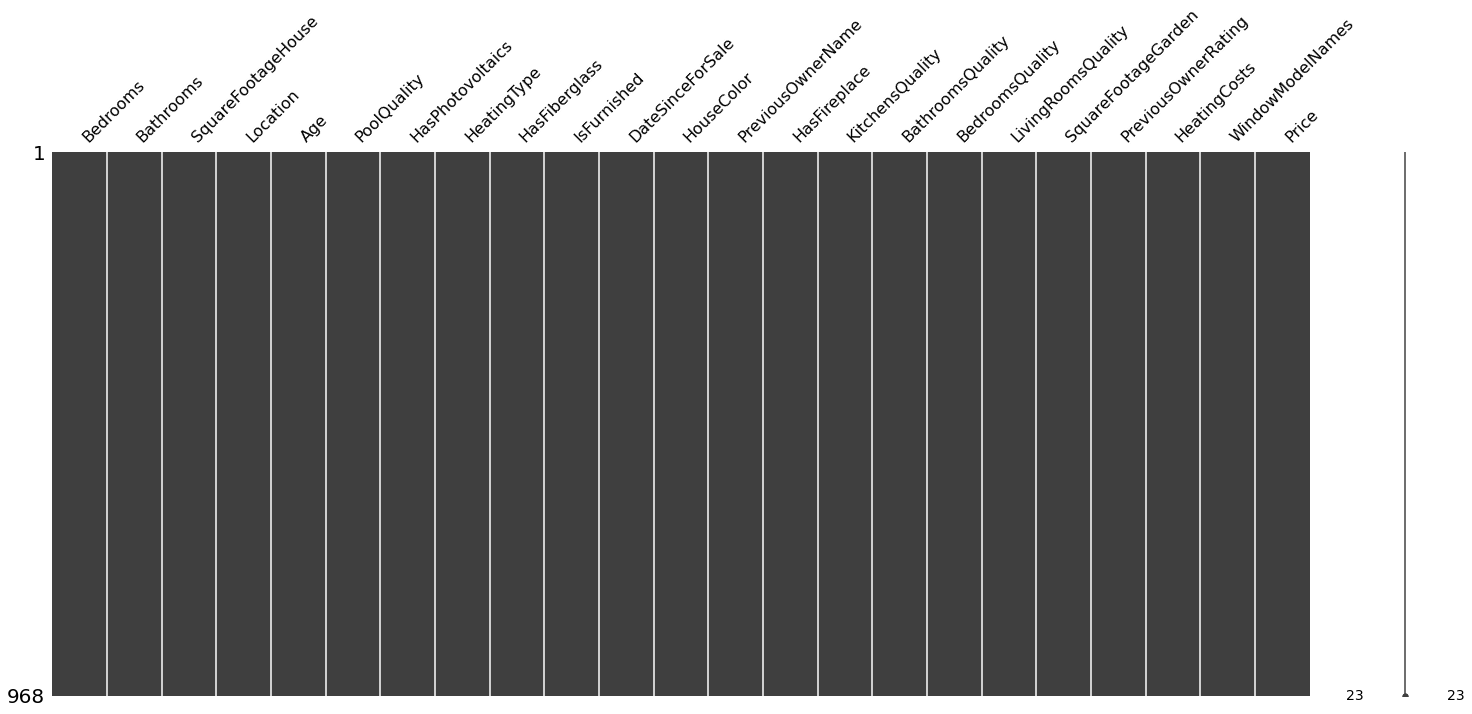

In [14]:
msno.matrix(df_clean)

Print all the values that the Feature can assume


In [15]:
def printColValues(df):
    for col in df.columns:
        print(f'\'{col}\' \t: {df[col].unique().tolist()}')

In [16]:
printColValues(df_clean)

'Bedrooms' 	: [1.0, 2.0, 5.0, 3.0, 4.0]
'Bathrooms' 	: [1.0, 2.0, 3.0, 5.0, 4.0]
'SquareFootageHouse' 	: [57.0, 92.0, 100.0, 150.0, 82.82, 45.0, 41.0, 122.0, 91.0, 116.0, 105.0, 25.0, 81.0, 82.0, 43.0, 76.0, 22.0, 28.0, 139.0, 52.0, 93.0, 71.0, 78.0, 23.0, 44.0, 60.0, 95.0, 129.0, 136.0, 59.0, 36.0, 84.0, 123.0, 27.0, 146.0, 120.0, 101.0, 51.0, 29.0, 107.0, 46.0, 111.0, 68.0, 86.0, 133.0, 98.0, 149.0, 26.0, 96.0, 63.0, 50.0, 56.0, 124.0, 64.0, 75.0, 32.0, 143.0, 142.0, 114.0, 80.0, 103.0, 135.0, 115.0, 118.0, 31.0, 117.0, 72.0, 33.0, 39.0, 138.0, 137.0, 62.0, 73.0, 90.0, 42.0, 97.0, 65.0, 106.0, 66.0, 83.0, 55.0, 53.0, 48.0, 130.0, 69.0, 85.0, 128.0, 38.0, 35.0, 54.0, 58.0, 89.0, 20.0, 134.0, 132.0, 109.0, 74.0, 34.0, 94.0, 144.0, 112.0, 110.0, 47.0, 102.0, 113.0, 49.0, 88.0, 141.0, 131.0, 126.0, 127.0, 67.0, 24.0, 30.0, 119.0, 148.0, 140.0, 125.0, 61.0, 77.0, 40.0, 37.0, 99.0, 87.0, 121.0, 145.0, 70.0, 108.0, 21.0, 104.0, 147.0, 79.0, 19.0]
'Location' 	: ['Rural', 'Suburban', 'Urban']

# **Scaling**
Scaling some features in order to ensure they have similar ranges for ML applications

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_clean['TotArea'] = (df_clean['SquareFootageHouse'] + df_clean['SquareFootageGarden']).astype(float)
cols = ['SquareFootageHouse','SquareFootageGarden', 'DateSinceForSale', 'Age', 'SquareFootageGarden', 'HeatingCosts', 'PreviousOwnerRating', 'TotArea']
df_clean_without_scaling = df_clean.copy()
df_clean[cols] = scaler.fit_transform(df_clean[cols])

##### Encoding Categorical Variables
Transfroming Categorical variables to Numerical by applying the One-Hot Encoding


In [18]:
def dummy_encode(df):
    cols = ['Location', 'PoolQuality', 'HeatingType', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames', 'HouseColor', 'PreviousOwnerName']

    for col in cols:
        dummies = pd.get_dummies(df[col])
        df      = pd.concat([df, dummies], axis='columns')
        df      = df.drop([col], axis='columns')
    return df


# **Data Visualization**

In [19]:
def inspect(df):
    # Number of rows and columns for the subplots
    numericalF = ['SquareFootageHouse', 'Age', 'DateSinceForSale', 'PreviousOwnerRating', 'HeatingCosts']
    categoricalF = ['Bedrooms', 'Bathrooms', 'Location', 'PoolQuality', 'HasPhotovoltaics', 'HeatingType', 'SquareFootageGarden', 'HasFiberglass', 'IsFurnished', 'HasFireplace', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames', 'PreviousOwnerName', 'HouseColor']
    num_rows = len(categoricalF) // 3 + (len(categoricalF) % 3 > 0)
    num_cols = 3
    plt.figure(figsize=(30, 7 * num_rows))

    print("Inspecting Categorical features-Target relationship")
    for i, feature in enumerate(categoricalF):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.color_palette("husl", 9)
        sns.histplot(data=df, x='Price', hue=feature, kde=True, element='step', palette="husl")
        plt.title(f'Price Distribution by {feature.title()}', fontsize=16, fontweight='bold')
        plt.ylabel("Count", fontsize=14, fontweight='bold')
        plt.xlabel("Price", fontsize=14, fontweight='bold')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Visualizing the correlation between numerical features
    numericalF_df = df.select_dtypes(include=[np.number])
    print("Inspecting Confusion matrix between Numerical features")

    plt.figure(figsize=(15, 11))
    corrMat = numericalF_df.corr()
    sns.heatmap(corrMat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

    # Create scatter plots
    plt.figure(figsize=(20, 15))

    print("Inspecting Numerical feature-Target relationship")
    for i, feature in enumerate(numericalF):
        plt.subplot(3, 3, i + 1)
        sns.regplot(data=df, x=feature, y='Price', line_kws={"color": "red"})
        plt.title(f'Scatter plot of {feature} vs Price', fontweight='bold')
        plt.xlabel(feature)
        plt.ylabel('Price')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Print a correlation matrix of a DF
def plotCorrMat(df):
    plt.figure(figsize=(15, 11))
    corrMat = df.corr()
    sns.heatmap(corrMat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features DF', fontsize=24, fontweight='bold')
    plt.show()

# Print a correlation matrix of a DF, in a sorted order, correlating only with 'Price'
def topCorrelatedConfMat(df):
    numerical_values = df[list(df.select_dtypes(include=[np.number]))]
    # Get the more correlated variables by sorting in descending order for the SalePrice column
    ix = numerical_values.corr().sort_values('Price', ascending=False).index
    df_sorted_by_correlation = numerical_values.loc[:, ix]
    # Take only the first 15 more correlated variables
    fifteen_more_correlated = df_sorted_by_correlation.iloc[:, :15]
    corr = fifteen_more_correlated.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(20,13))
    with sns.axes_style("white"):
        # Display a correlation heatmap
        ax = sns.heatmap(corr, mask=mask, annot=True)

Inspecting Categorical features-Target relationship


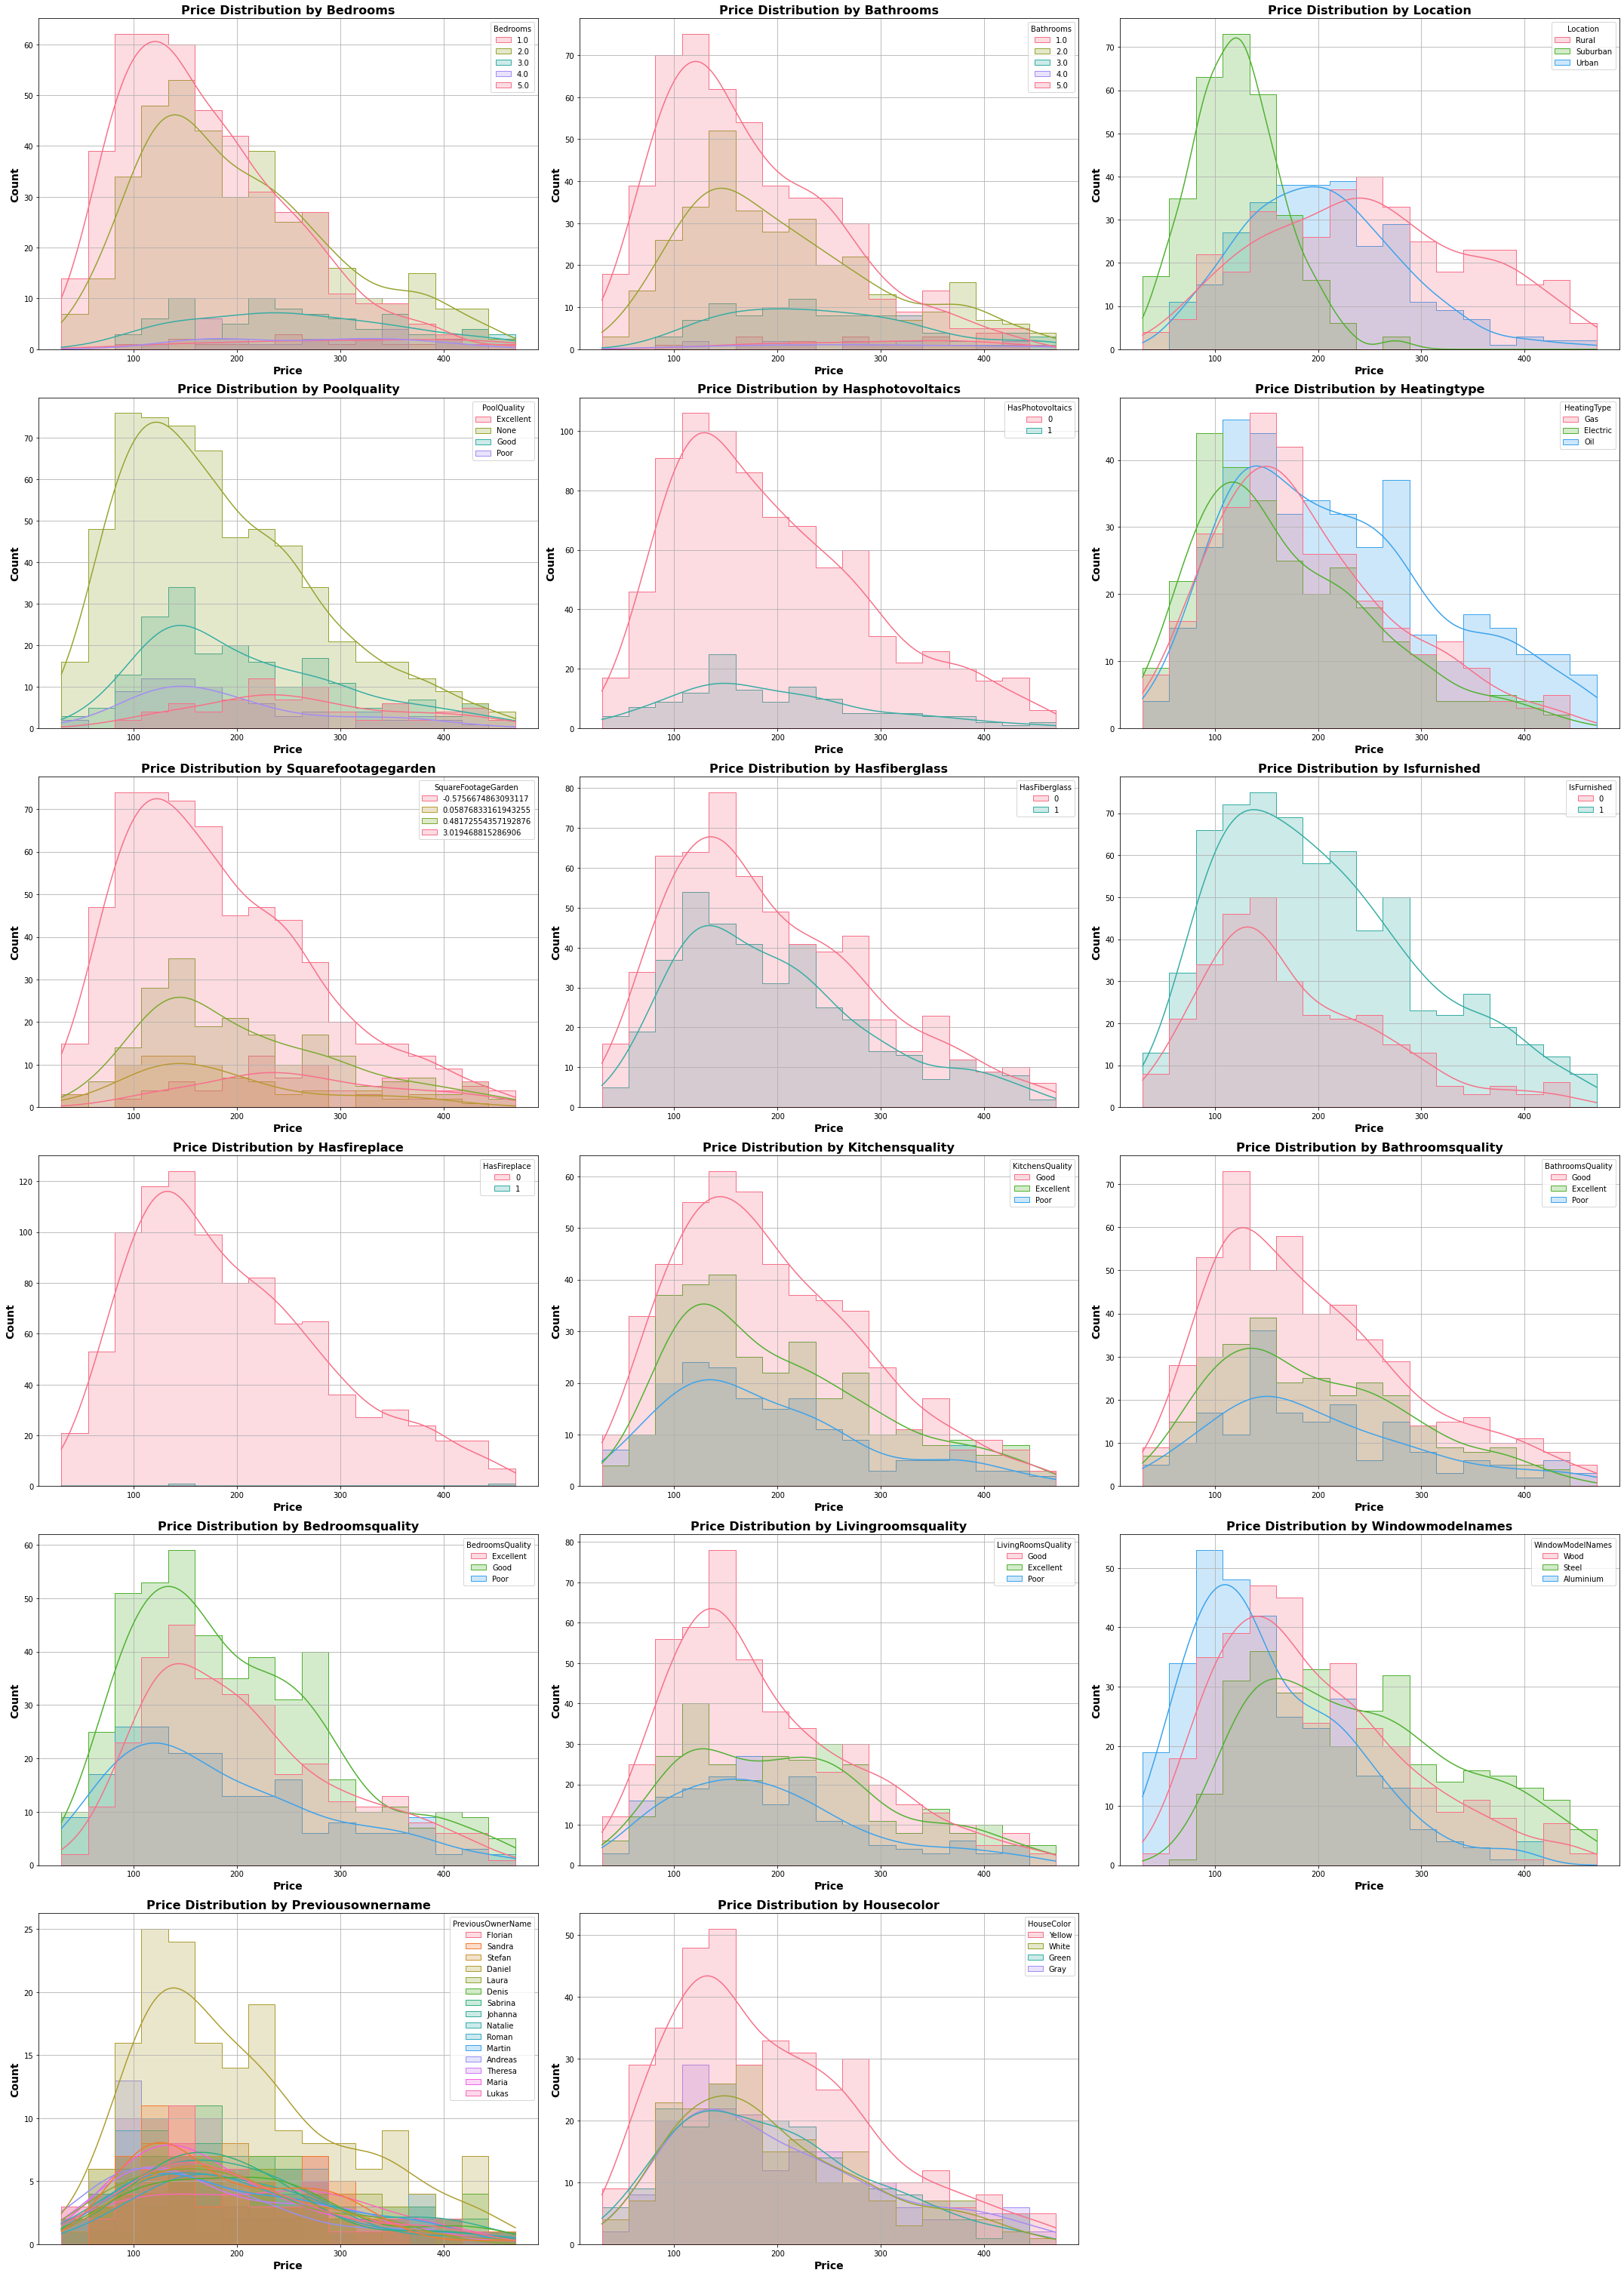

Inspecting Confusion matrix between Numerical features


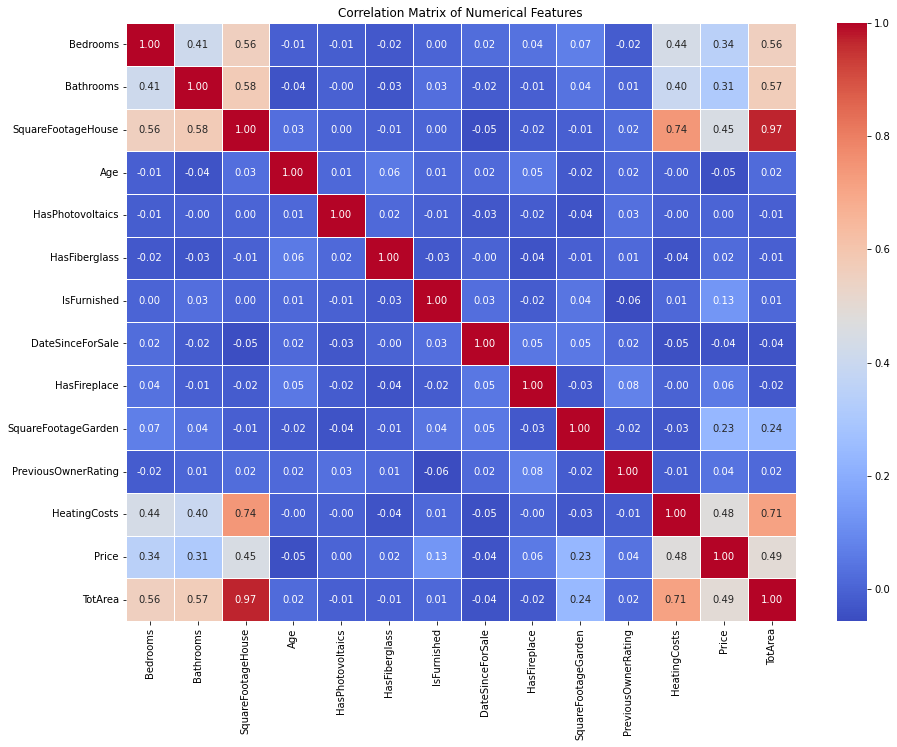

Inspecting Numerical feature-Target relationship


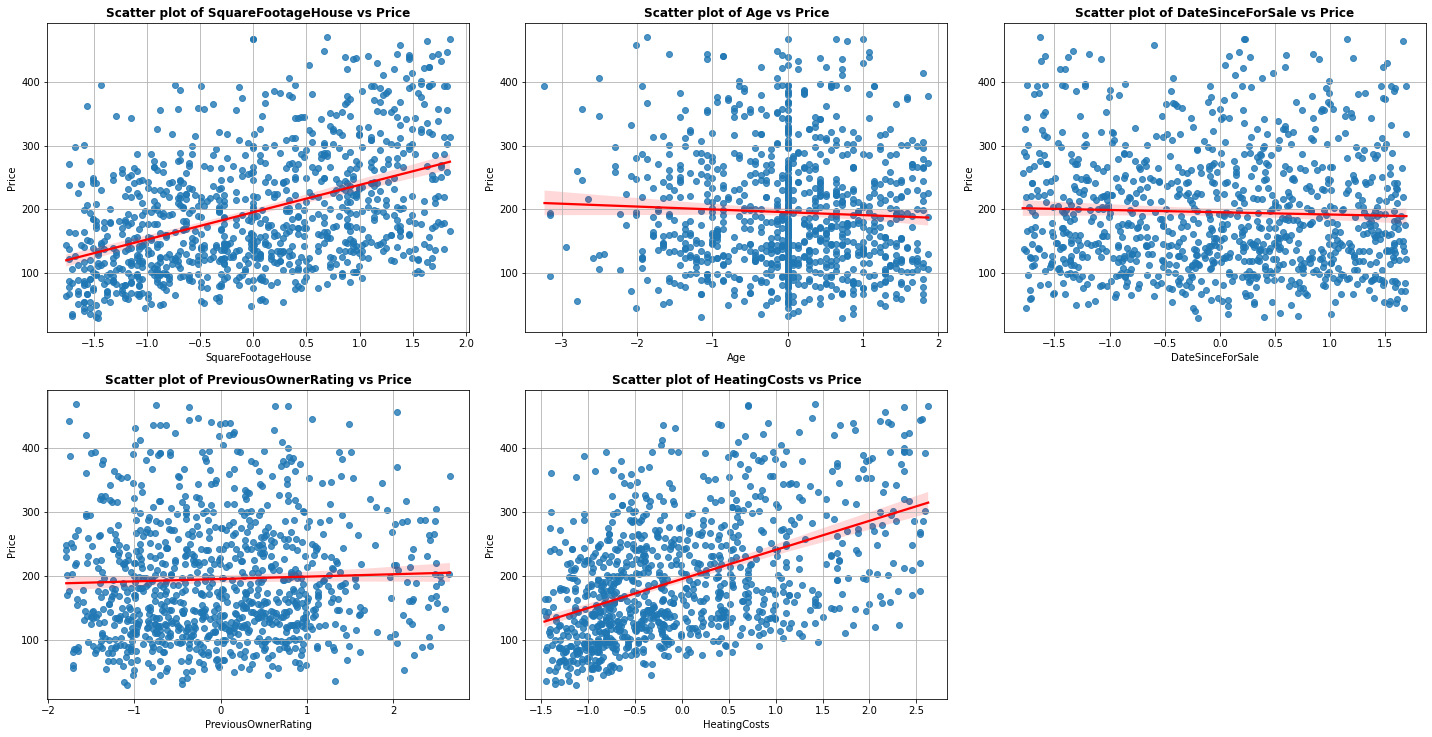

In [20]:
inspect(df_clean)

In [21]:
df_clean = dummy_encode(df_clean)
df_new = df_clean.copy()

## **`Correlation between Price and other features`**:


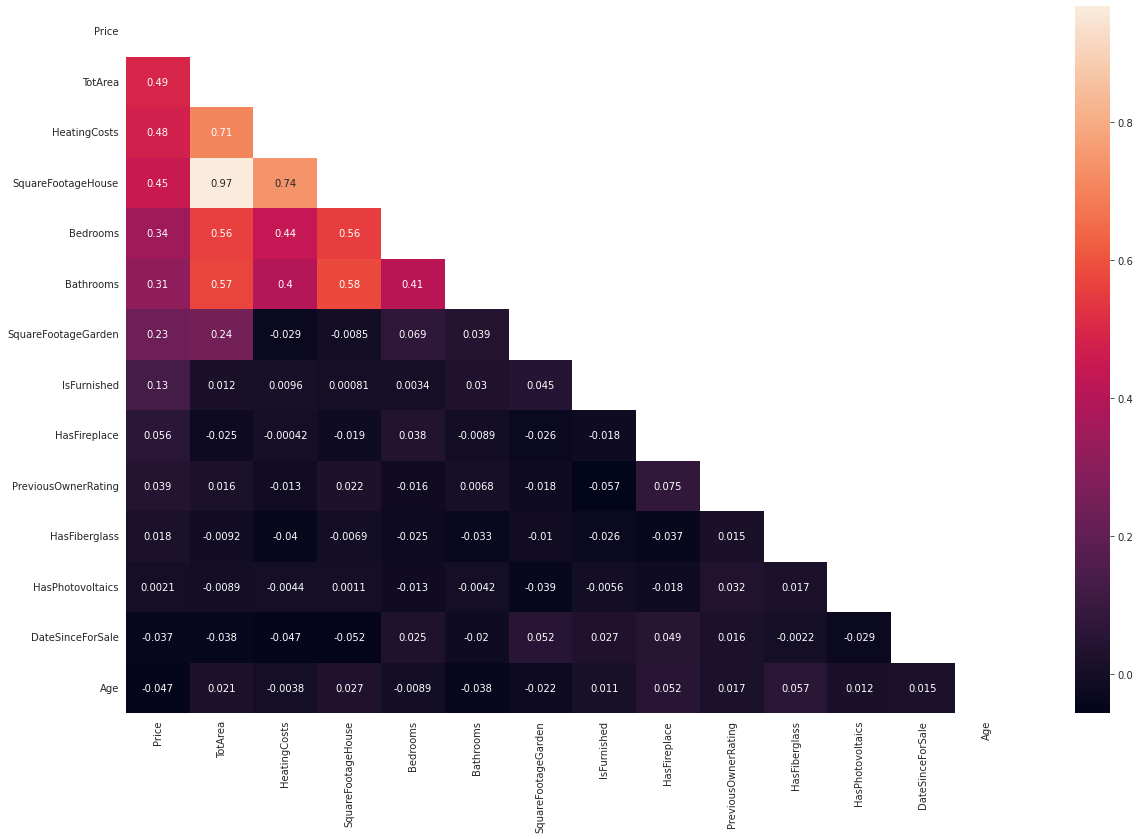

In [22]:
topCorrelatedConfMat(df_new)

In [23]:
correlations = df_new.corrwith(df_clean['Price']).sort_values(ascending=False)
print(correlations)

Price                  1.000000
TotArea                0.494768
HeatingCosts           0.478416
SquareFootageHouse     0.449597
Rural                  0.444494
Bedrooms               0.344498
Steel                  0.326309
Bathrooms              0.311681
SquareFootageGarden    0.232789
Excellent              0.204839
Oil                    0.197479
IsFurnished            0.129787
Excellent              0.110120
Good                   0.068460
Excellent              0.059173
HasFireplace           0.055603
Urban                  0.052713
Lukas                  0.046625
Denis                  0.042062
Gray                   0.041746
PreviousOwnerRating    0.039047
Daniel                 0.038548
Johanna                0.034768
Excellent              0.034201
Poor                   0.026998
Roman                  0.022561
HasFiberglass          0.017914
Martin                 0.013035
Excellent              0.003376
HasPhotovoltaics       0.002123
Stefan                 0.001146
Green   

### Splitting

In [24]:
from sklearn.model_selection import train_test_split
X = df_new.drop('Price', axis=1)
y = df_new['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **MODEL TRAINING**
The function 'evaluation' evaluates the performance of a machine learning model, particularly for regression problems. This function calculates and prints various statistical errors that quantify the discrepancies between the values predicted by the model and the actual values:

1.   **Root Mean Squared Error (RMSE)**
2.   **Mean Squared Error (MSE)**
3.    **Mean Absolute Error (MAE)**
4. **R^2 Score (coefficient of determination)**

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluation(model, x_train_std, y_train, x_test, y_test, train=True):
    if train:
        pred = model.predict(x_train_std)

        # Compute errors and parameters
        rmse_train = np.sqrt(mean_squared_error(y_train, pred))
        mse_train = mean_squared_error(y_train, pred)
        mae_train = mean_absolute_error(y_train, pred)
        r2_train = r2_score(y_train, pred)

        # Plot of errors
        plt.figure(figsize=(10, 6))
        plt.plot(y_train, pred, 'o', label='Predicted vs. Actual (Training)')
        plt.plot(y_train, y_train, color='red', label='Regression Line')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predicted vs. Actual Values (Training)')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Train Result:\n================================================")
        print(f"Root Mean Squared Error: {rmse_train}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mse_train}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: {mae_train}")
        print("_______________________________________________")
        print(f"R^2 Score: {r2_train}")
        print("_______________________________________________")

    print()

    if not train:
        pred = model.predict(x_test)

        rmse_test = np.sqrt(mean_squared_error(y_test, pred))
        mse_test = mean_squared_error(y_test, pred)
        mae_test = mean_absolute_error(y_test, pred)
        r2_test = r2_score(y_test, pred)

        plt.figure(figsize=(10, 6))
        plt.plot(y_test, pred, 'o', label='Predicted vs. Actual (Test)')
        plt.plot(y_test, y_test, color='red', label='Regression Line')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predicted vs. Actual Values (Test)')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Test Result:\n================================================")
        print(f"Root Mean Squared Error: {rmse_test}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mse_test}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: {mae_test}")
        print("_______________________________________________")
        print(f"R^2 Score: {r2_test}")
        print("_______________________________________________")

# **Selected model : Random Forest Regression**
Using Random Search to find best parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters found:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'bootstrap': True}


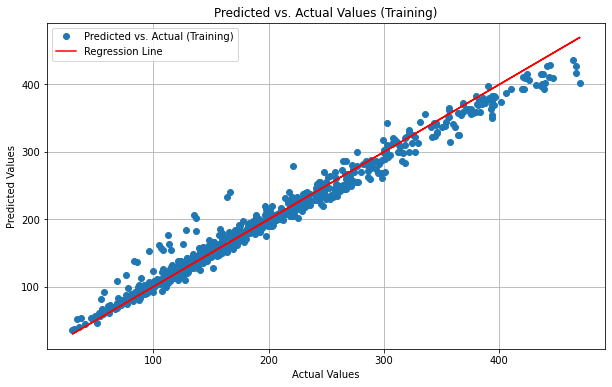

Train Result:
Root Mean Squared Error: 14.542842727532335
_______________________________________________
Mean Squared Error: 211.49427459774014
_______________________________________________
Mean Absolute Error: 9.66144312943151
_______________________________________________
R^2 Score: 0.9761225338937475
_______________________________________________




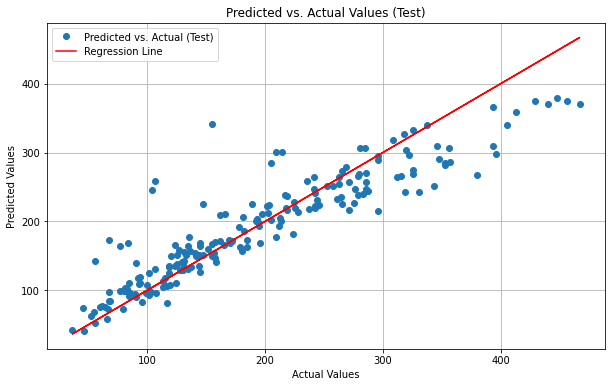

Test Result:
Root Mean Squared Error: 41.25893479701218
_______________________________________________
Mean Squared Error: 1702.2997005841023
_______________________________________________
Mean Absolute Error: 27.954879397113416
_______________________________________________
R^2 Score: 0.827369063411799
_______________________________________________


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}


random_forest_model = RandomForestRegressor(random_state=0)

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest_model,
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Randomized parameter search
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters found: ", best_params)

# Evaluation on the model with the best parameters
best_model = random_search.best_estimator_
evaluation(best_model, X_train, y_train, X_test, y_test, train=True)
evaluation(best_model, X_train, y_train, X_test, y_test, train=False)


# **Other models tested and discarded**



# 1.   Linear Regression
# 2.   Decision Tree Regression



LinearRegression evaluation on training set


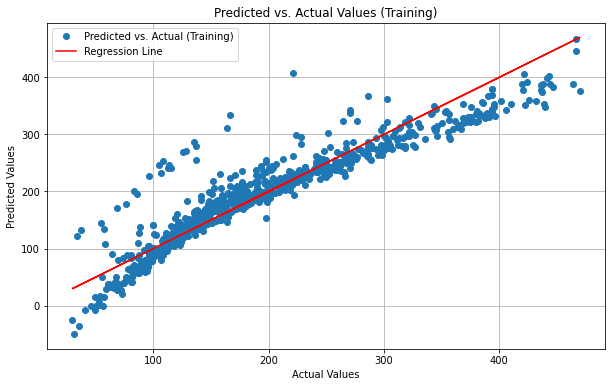

Train Result:
Root Mean Squared Error: 33.87673156730803
_______________________________________________
Mean Squared Error: 1147.6329416834442
_______________________________________________
Mean Absolute Error: 22.101456963824287
_______________________________________________
R^2 Score: 0.8704335296093251
_______________________________________________

Decision Tree Regression evaluation on training set


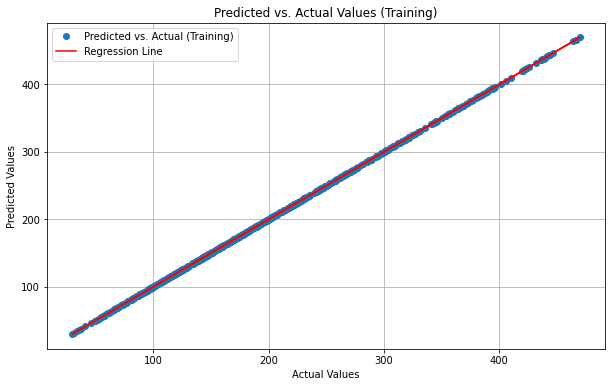

Train Result:
Root Mean Squared Error: 0.0
_______________________________________________
Mean Squared Error: 0.0
_______________________________________________
Mean Absolute Error: 0.0
_______________________________________________
R^2 Score: 1.0
_______________________________________________



In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Linear Regression - Training results better for random forest model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print('LinearRegression evaluation on training set')
evaluation(linear_model, X_train, y_train, X_test, y_test, train=True)

# Decision Tree Regression - seems to overfit
decision_tree_model = DecisionTreeRegressor(random_state=0)
decision_tree_model.fit(X_train, y_train)
print('Decision Tree Regression evaluation on training set')
evaluation(decision_tree_model, X_train, y_train, X_test, y_test, train=True)

# QUESTION 1:

*If I have a budget of €100,000, what kind of houses will I be able to buy?*

In [28]:
# Predict house prices using the Random Forest model
df_questions = df_clean_without_scaling.drop(columns=['Price'])
predicted_prices = best_model.predict(df_new.drop(columns=['Price']))

# Add the predicted prices to the DataFrame
df_questions['predicted_price'] = predicted_prices

# Filter the DataFrame to find houses within the budget of €100,000
affordable_houses = df_questions[df_questions['predicted_price'] <= 100]

print("Features of houses within the budget of €100,000:")
print(affordable_houses)

# Count how many values are less than €100,000
num_houses_under_100 = np.sum(predicted_prices <= 100)

print(f"The number of houses with a price below 100 is: {num_houses_under_100}")

print(f"Minimum square footage of them: {affordable_houses['SquareFootageHouse'].min()}")
print(f"Maximum square footage of them: {affordable_houses['SquareFootageHouse'].max()}")

Features of houses within the budget of €100,000:
     Bedrooms  Bathrooms  SquareFootageHouse  Location        Age PoolQuality   
6         1.0        2.0                41.0  Suburban  44.991422        None  \
12        1.0        1.0                25.0     Rural  49.000000        None   
13        2.0        1.0                81.0  Suburban  45.000000        None   
25        1.0        2.0                71.0  Suburban  44.991422        None   
26        1.0        2.0                78.0  Suburban  61.000000        None   
..        ...        ...                 ...       ...        ...         ...   
983       1.0        1.0                28.0     Urban  57.000000        None   
984       1.0        1.0                52.0  Suburban  22.000000        None   
987       2.0        1.0                61.0  Suburban  39.000000        Good   
993       1.0        2.0                62.0  Suburban  30.000000        None   
997       2.0        1.0                38.0  Suburban  38.

In [29]:
# Calculate the mean of numerical features
numerical_mean = affordable_houses[['SquareFootageHouse', 'Age', 'SquareFootageGarden', 'PreviousOwnerRating', 'HeatingCosts', 'predicted_price']].mean()
print("Mean of numerical features:")
print(numerical_mean)
print()

# Calculate the mode of non-numerical features
non_numerical_mode = affordable_houses[['Bedrooms', 'Bathrooms', 'Location', 'PoolQuality', 'HeatingType', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames']].mode().iloc[0]
print("Mode of non-numerical features:")
print(non_numerical_mode)

Mean of numerical features:
SquareFootageHouse     47.827805
Age                    45.120696
SquareFootageGarden     7.357724
PreviousOwnerRating     2.395854
HeatingCosts           46.320945
predicted_price        80.132391
dtype: float64

Mode of non-numerical features:
Bedrooms                    1.0
Bathrooms                   1.0
Location               Suburban
PoolQuality                None
HeatingType            Electric
KitchensQuality            Good
BathroomsQuality           Good
BedroomsQuality            Good
LivingRoomsQuality         Good
WindowModelNames      Aluminium
Name: 0, dtype: object


In [30]:
# Filter the DataFrame to obtain Urban, Suburban and Rural houses separately
suburban_houses = affordable_houses[affordable_houses['Location'] == 'Suburban']
urban_houses = affordable_houses[affordable_houses['Location'] == 'Urban']
rural_houses = affordable_houses[affordable_houses['Location'] == 'Rural']

# Calculate the mean of numerical features for each subset
numerical_mean_suburban = suburban_houses[['SquareFootageHouse', 'Age', 'SquareFootageGarden', 'PreviousOwnerRating', 'HeatingCosts', 'predicted_price']].mean()
numerical_mean_urban = urban_houses[['SquareFootageHouse', 'Age', 'SquareFootageGarden', 'PreviousOwnerRating', 'HeatingCosts', 'predicted_price']].mean()
numerical_mean_rural = rural_houses[['SquareFootageHouse', 'Age', 'SquareFootageGarden', 'PreviousOwnerRating', 'HeatingCosts', 'predicted_price']].mean()

# Calculate the mode of non-numerical features for each subset
non_numerical_mode_suburban = suburban_houses[['Bedrooms', 'Bathrooms', 'PoolQuality', 'HeatingType', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames']].mode().iloc[0]
non_numerical_mode_urban = urban_houses[['Bedrooms', 'Bathrooms', 'PoolQuality', 'HeatingType', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames']].mode().iloc[0]
non_numerical_mode_rural = rural_houses[['Bedrooms', 'Bathrooms', 'PoolQuality', 'HeatingType', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality', 'WindowModelNames']].mode().iloc[0]

# Print the results
print("Mean of numerical features for Suburban houses:")
print(numerical_mean_suburban)
print()

print("Mode of non-numerical features for Suburban houses:")
print(non_numerical_mode_suburban)
print()

print("Mean of numerical features for Urban houses:")
print(numerical_mean_urban)
print()

print("Mode of non-numerical features for Urban houses:")
print(non_numerical_mode_urban)
print()

print("Mean of numerical features for Urban houses:")
print(numerical_mean_rural)
print()

print("Mode of non-numerical features for Rural houses:")
print(non_numerical_mode_rural)


Mean of numerical features for Suburban houses:
SquareFootageHouse     52.635385
Age                    45.471302
SquareFootageGarden     7.835165
PreviousOwnerRating     2.404725
HeatingCosts           50.218740
predicted_price        78.953463
dtype: float64

Mode of non-numerical features for Suburban houses:
Bedrooms                   1.0
Bathrooms                  1.0
PoolQuality               None
HeatingType           Electric
KitchensQuality           Good
BathroomsQuality          Good
BedroomsQuality           Good
LivingRoomsQuality        Good
WindowModelNames          Wood
Name: 0, dtype: object

Mean of numerical features for Urban houses:
SquareFootageHouse     37.125000
Age                    47.686428
SquareFootageGarden     5.625000
PreviousOwnerRating     2.313750
HeatingCosts           39.073180
predicted_price        85.059950
dtype: float64

Mode of non-numerical features for Urban houses:
Bedrooms                    1.0
Bathrooms                   1.0
PoolQuality

# QUESTION 2:
*How much money can I save if I decide not to get a house with a pool?*

In [34]:
# Filter the test set to get the two subsets (selected houses with pool and without pool).
houses_with_pool = df_questions[df_questions['PoolQuality'] != 'None']
houses_without_pool = df_questions[df_questions['PoolQuality'] == 'None']

# Compute the minimum and mean prices for the houses without pool
min_price_without_pool = houses_without_pool['predicted_price'].min()
print(f"Minimal house price without pool: {np.round(min_price_without_pool, 3)}€")
mean_price_without_pool = houses_without_pool['predicted_price'].mean()
print(f"Average house price without pool: {np.round(mean_price_without_pool, 3)}€")

# Compute the minimum and mean prices for the houses with pool
min_price_with_pool = houses_with_pool['predicted_price'].min()
print(f"Minimal house price with pool: {np.round(min_price_with_pool, 3)}€")
mean_price_with_pool = houses_with_pool['predicted_price'].mean()
print(f"Average house price with pool: {np.round(mean_price_with_pool, 3)}€")

# Compute the minimum saving
saving_min = min_price_with_pool - min_price_without_pool
print(f"Minimum savings by buying a house without a pool: {np.round(saving_min, 3)}€")

# Compute the average saving
saving_mean = mean_price_with_pool - mean_price_without_pool
print(f"Average savings by buying a house without a pool: {np.round(saving_mean, 3)}€")

Minimal house price without pool: 36.178€
Average house price without pool: 185.511€
Minimal house price with pool: 44.019€
Average house price with pool: 211.376€
Minimum savings by buying a house without a pool: 7.842€
Average savings by buying a house without a pool: 25.865€
